# Switzerland Road Traffic Accidents Forecasting

In this notebook we will try to forecast road traffic accidents in switzerland using the "Strassenverkehrsunfallorte" dataset available at the following address: https://opendata.swiss/en/dataset/strassenverkehrsunfalle-mit-personenschaden

__Planned Work__: 
- Accidents localisation visualization.
- Accidents number forecasting for 2019
- Accidents number forecasting for 2018 to check that it matches with reality (TBD)

__Dataset Description:__ Anonymised visualisation and positioning of road traffic accidents with injury to persons since 2011. Information on the year, the month, the weekday, the time of the accident, the type of road, the type of accident and the category of severity is provided for road traffic accidents.

## Importation of libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
from datetime import datetime
from colorcet import fire
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py

# Data loading and cleaning
We load the dataset and basic cleaning of the data:
- replace the nan values by doing a forward fill
- keeping only relevant columns for our work

In [2]:
df = pd.read_csv('RoadTrafficAccidentLocations.csv')
df.head()
df = df.fillna(method='ffill')

In [3]:
original_columns = df.columns
columns2keep = ['AccidentUID', 'AccidentType', 'AccidentType_en',
                'AccidentSeverityCategory', 'AccidentSeverityCategory_en',
                'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
                'AccidentInvolvingMotorcycle', 'RoadType', 'RoadType_en',
                'AccidentLocation_CHLV95_E', 'AccidentLocation_CHLV95_N',
                'CantonCode', 'MunicipalityCode', 'AccidentYear',
                'AccidentMonth', 'AccidentMonth_en', 'AccidentWeekDay',
                'AccidentWeekDay_en', 'AccidentHour', 'AccidentHour_text']
df = df[columns2keep]
df['AccidentType'] = df.AccidentType.astype('category')
df['AccidentWeekDay'] = df['AccidentWeekDay'].str[-1:].astype(int)
df.head(2)

,AccidentUID,AccidentType,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_en,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,RoadType_en,...,AccidentLocation_CHLV95_N,CantonCode,MunicipalityCode,AccidentYear,AccidentMonth,AccidentMonth_en,AccidentWeekDay,AccidentWeekDay_en,AccidentHour,AccidentHour_text
0,9FD6441F802C20A6E0430A865E3320A6,at0,Accident with skidding or self-accident,as3,Accident with light injuries,False,True,False,rt433,Minor road,...,1246980,ZH,261,2011,1,January,6,Saturday,1.0,01h-02h
1,99AE7B25356510B0E0430A865E3310B0,at4,Accident when turning-into main road,as3,Accident with light injuries,False,False,True,rt433,Minor road,...,1117371,GE,6621,2011,1,January,6,Saturday,1.0,01h-02h


## Visualization
As the dataset is quite big, instead of using the classical scatter from matplotlib, I prefer to use datashader which suits perfectly the kind of plot I want. I used it a lot at work to plot some airplane trajectories following this work: https://examples.pyviz.org/opensky/opensky.html

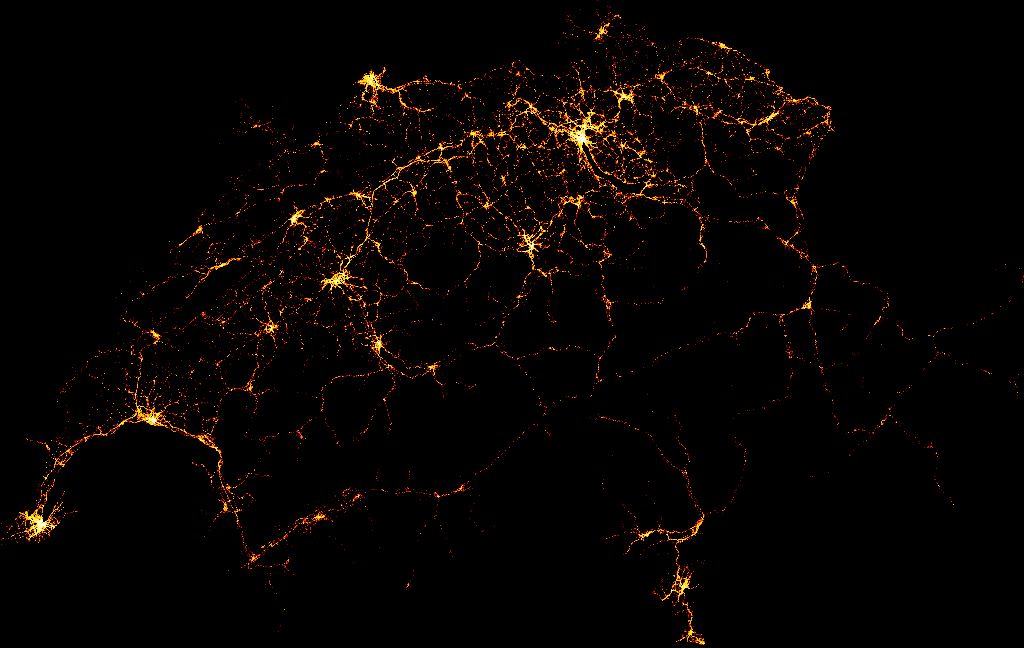

In [10]:
def bigdf_plot(data: pd.DataFrame, x_name: str, y_name: str, catEn=False, cat='None'):
    # Define Canvas
    x_center = (data[x_name].max() + data[x_name].min())/2
    y_center = (data[y_name].max() + data[y_name].min())/2

    x_half_range = (data[x_name].max()-data[x_name].min())/2
    y_half_range = (data[y_name].max()-data[y_name].min())/2
    x_range, y_range = ((x_center - x_half_range, x_center + x_half_range),
                        (y_center-y_half_range, y_center+y_half_range))
    plot_width = 1024
    plot_height = int(plot_width/(x_half_range/y_half_range))

    def categorical_color_key(ncats, cmap):
        mapper = get_cmap(cmap)
        return [str(rgb2hex(mapper(i))) for i in np.linspace(0, 1, ncats)]

    def create_image(x_range=x_range, y_range=y_range, w=plot_width,
                     h=plot_height, aggregator=ds.count(),
                     categorical=None, black=False, cmap="blue"):
        opts = {}
        if categorical and cmap:
            opts['color_key'] = categorical_color_key(
                    len(data[aggregator.column].unique()), cmap)
        cvs = ds.Canvas(plot_width=w, plot_height=h,
                        x_range=x_range, y_range=y_range)
        agg = cvs.points(data, x_name, y_name,  aggregator)
        img = tf.shade(agg, cmap=cmap, **opts)
        if black:
            img = tf.set_background(img, 'black')
        return img

    if catEn:
        return create_image(aggregator=ds.count_cat(cat),
                            cmap=fire,
                            black=True)
    else:
        return create_image(aggregator=ds.count(), cmap=fire, black=True)
    
bigdf_plot(df, 'AccidentLocation_CHLV95_E', 'AccidentLocation_CHLV95_N')

# Transforming the dataset into a timeseries
## Obtaining the missing day number of the month:
The original dataset misses an important column: The day number of the month !
We have the year, the month, the day (monday, tuesday, ...) but not the number which is a bit weird ...
Therefore, assuming that the dataset index is ordered in time and that there is at least one accident per day, we will try to reconstruct it.

I have done some unit tests by checking that the corrsponding day number reconstructed matches with the day corresponding to the date of interest. Unfortunately those unit tests are a necessary condition but not sufficient ...

In [4]:
groups = df.groupby(['AccidentYear', 'AccidentMonth', 'AccidentWeekDay'])

# The goal is to check when the day as well as the month are changing.
df['day_change'] = np.append(0, np.diff(df.AccidentWeekDay)) # We need to add the last value
df['month_change'] = np.append(0, np.diff(df.AccidentMonth)) # We need to add the last value
df[['month_change', 'day_change']]

df['AccidentDay'] = 1
n_day = []  # List containing the day numbers of each row in the dataframe
for index in range(len(df)):
    if index == 0:
        n_day.append(1)
    elif df['month_change'].values[index] != 0:
        n_day.append(1) # If month changing we start back at the 1st of the month
    elif df['day_change'].values[index] != 0:
        n_day.append(n_day[-1] +1 ) # If the day is changing we increment the number
    else:
        n_day.append(n_day[-1])  # If not we keep the same day number 
df['AccidentDay'] = np.array(n_day, dtype=np.int)


## Timeseries transformation

In [5]:
df.AccidentHour.isna().sum()
df['Year'] = df.AccidentYear.astype('str')
df['Month'] = df.AccidentMonth.astype('str')
df['Day'] = df.AccidentDay.astype('str')
df['AccidentHour'] = df.AccidentHour.astype(int)
df['Hour'] = df.AccidentHour.astype('str')

df['timestamp'] = df.Year + ' ' + df.Month + ' ' + df.Day + ' ' + df.Hour
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x, '%Y %m %d %H'))

df = df.set_index('timestamp')


# Counting the number of accident per hour:
Now we want to know for each hour we have in our dataset, how many accidents occured in Switzerland

,n_accident
count,49355.000000
mean,2.908702
std,2.137959
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,26.000000


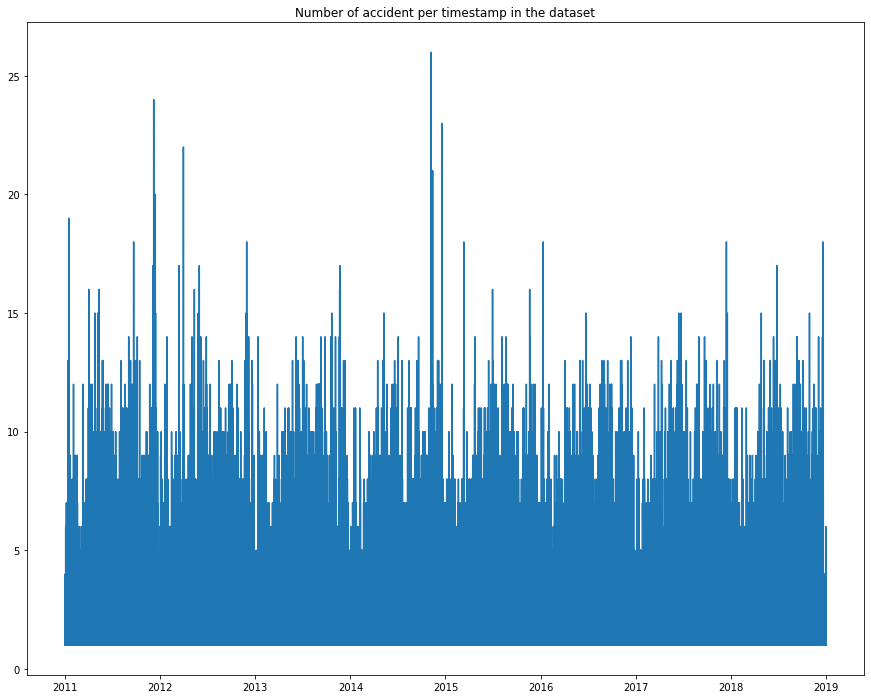

In [37]:
def get_df_count(df, dt=None, en_plot=False):
    if dt is not None:
        df = df.reset_index()
        df.timestamp =  df.timestamp.dt.round(dt)
        df = df.set_index('timestamp')
    df_count = pd.DataFrame()
    df_count['n_accident'] = df.groupby('timestamp').AccidentUID.count()
    plt.figure(figsize=(15, 12))
    plt.plot(df_count['n_accident'])
    plt.title('Number of accident per timestamp in the dataset')
    return df_count

df_count = get_df_count(df, en_plot=True)

df_count.describe()

It is very difficult to extract any usefull information from this plot, we will therefore use the prophet toolbox.

# Number of accident analysis and forecasting using Facebook Prophet

For this study, I will just use the tools presented on this tutorial: https://facebook.github.io/prophet/docs/quick_start.html

In [30]:
df_count = df_count.reset_index()

# Dataframe must have columns 'ds' and 'y' with the dates and values respectively.
df_count.columns = ['ds', 'y']

m = Prophet()
m.fit(df_count)
future = m.make_future_dataframe(periods=1)
#%%
forecast = m.predict(future)

C:\Users\figu\AppData\Local\conda\conda\envs\crm_env_36\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



## Components analysis

This is one of my favorite tools from this toolbox. It extracts the trend, yearly seasonality, weekly and daily seasonality of the time series your are analyzing.

We can see that most of the accidents are happening at around 17H / 18H probably when the traffic is at most in switzerland. It also looks like that June is the most critical month but I can't find an easy explanation to this 

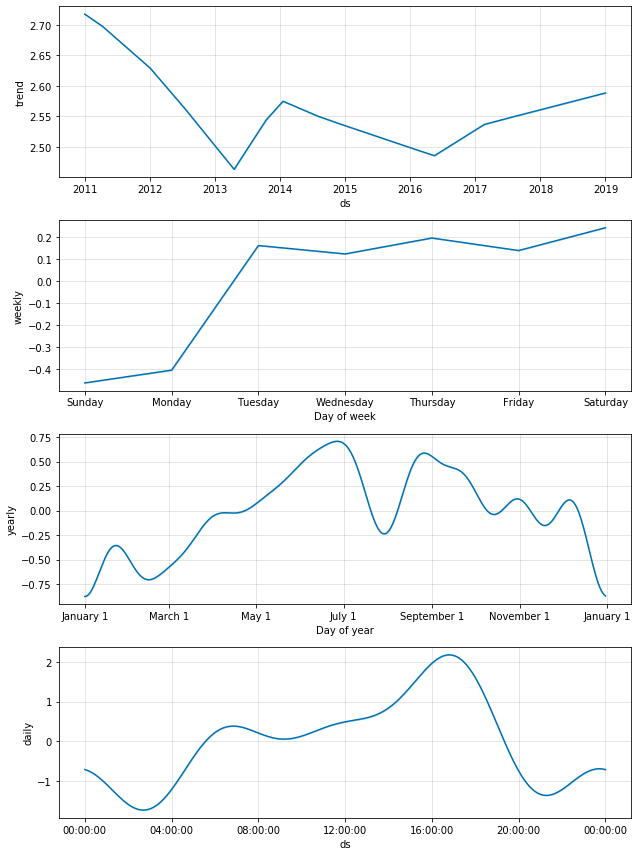

In [33]:
fig1 = m.plot_components(forecast)

## Forecasting for 2019

The resolution of accident per hour is to fine, to have a more meaningfull plot we will now extract the number of accidents per days.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
3283,2019-12-28,35.032323,19.106538,49.413869
3284,2019-12-29,21.560833,6.232288,36.886188
3285,2019-12-30,19.777211,4.913811,35.555119
3286,2019-12-31,28.975234,13.897697,44.316059
3287,2020-01-01,30.983533,15.350785,45.369749


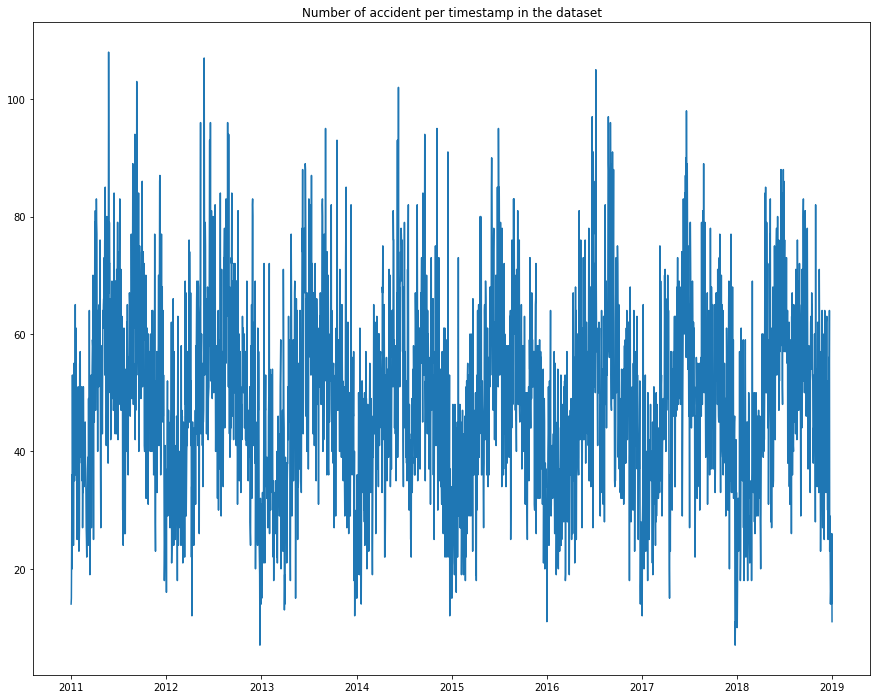

In [38]:
df_count = get_df_count(df, dt='1D')
df_count = df_count.reset_index()

# Dataframe must have columns 'ds' and 'y' with the dates and values respectively.
df_count.columns = ['ds', 'y']

m = Prophet()
m.fit(df_count)
future = m.make_future_dataframe(periods=365)
#%%
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



We see a nice decrease in number of daily accidents between 2011 and 2013, it would be interesting to know what is the reason. Unfortunately it looks like the number of daily road accidents will increase in 2019 follwing a tendency that started mid 2016.

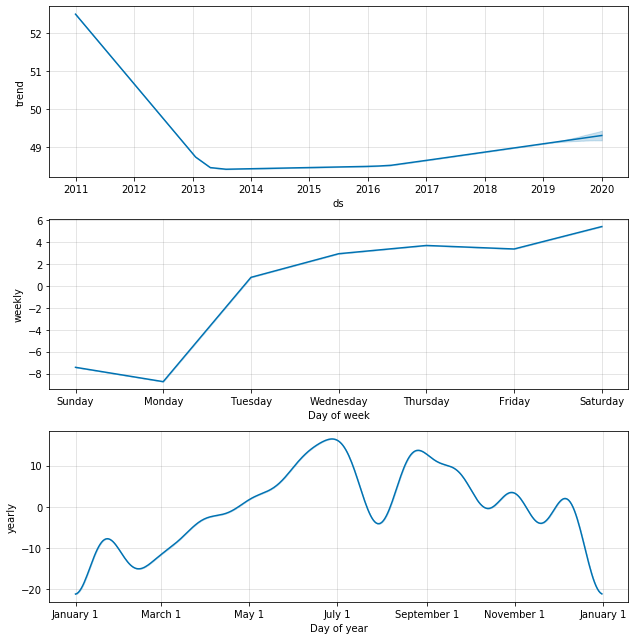

In [35]:
fig2 = m.plot_components(forecast)

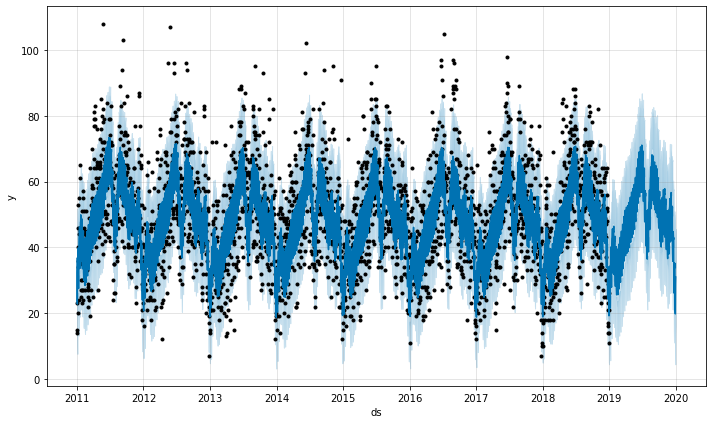

In [36]:
fig3 = m.plot(forecast)